# REINFORCE algorithm
The following code presents an agent using the REINFORCE algorithm and solving the short corridor problem in the Barton Sutto book, Reinforcement Learning: An Introduction.

In [7]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

class ShortCorridor:
    """
    Short corridor environment, see Example 13.1
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False

class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORCE Monte-Carlo Policy-Gradient Control (episodic)'
    """
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        self.x = np.array([[0, 1],
                           [1, 0]])
        self.rewards = []
        self.actions = []

    def get_pi(self):
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        # never become deterministic,
        # guarantees episode finish
        imin = np.argmin(pmf)
        epsilon = 0.05

        if pmf[imin] < epsilon:
            pmf[:] = 1 - epsilon
            pmf[imin] = epsilon

        return pmf

    def get_p_right(self):
        """Gets probability of moving right"""
        return self.get_pi()[1]

    def choose_action(self, reward):
        if reward is not None:
            self.rewards.append(reward)
        
        # Get policy
        pmf = self.get_pi()
        go_right = np.random.uniform() <= pmf[1]
        self.actions.append(go_right)

        return go_right

    def episode_end(self, last_reward):
        """
        
        """
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            # Retrieve action from time step
            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            
            # Calculate eligibility vector
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            
            # Calculate updates for parameters.
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi
            
            # Update theta accordingly using the gradient, alpha, gamma and G.
            self.theta += update
            # Update gamma_pow as we move further into the future where 
            # rewards matter less.
            gamma_pow *= self.gamma
        
        # Clean records so the next episode can start
        self.rewards = []
        self.actions = []


def figure_13_1():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    agent_generators = [lambda : ReinforceAgent(alpha=2e-4, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-2, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-3, gamma=gamma)]
    labels = ['alpha = 2e-4',
              'alpha = 2e-5',
              'alpha = 2e-3']

    rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

    for agent_index, agent_generator in enumerate(agent_generators):
        for i in tqdm(range(num_trials)):
            reward = trial(num_episodes, agent_generator)
            rewards[agent_index, i, :] = reward

    plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
    for i, label in enumerate(labels):
        plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')

    plt.show()

### REINFORCE agents' rewards
This figure shows the different total rewards to which each agent approaches to as they participate in more and more episodes. It is important to notice how the one approaching the actual optimal value is the medium sized step. This highlights the importance of choosing a good step size so that our agent doesn't jump over the correct answer but is also fast at converging.

100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


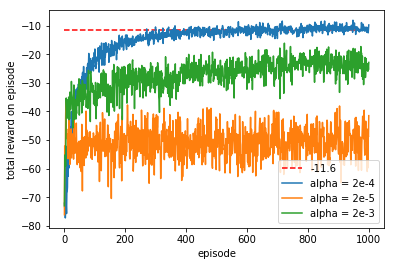

In [8]:
figure_13_1()